In [1]:
import numpy as np
import pandas as pd
import pymc as pm

import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
from arch import arch_model

from ipywidgets import HBox, VBox
from scipy.optimize import fmin, minimize
from scipy.stats import t
from scipy.stats import norm
from math import inf

import bs4 as bs
import requests
import yfinance as yf
import datetime

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import beta
import matplotlib.pyplot as plt

from statsmodels.distributions.empirical_distribution import ECDF

import tools as tl

# Read the CSV files
data1_cd4 = pd.read_csv("mt-datasets/Donor1_CD4_Genes.csv")
data2_cd4 = pd.read_csv("mt-datasets/Donor2_CD4_Genes.csv")
data1_cd4 = tl.TPM(data1_cd4)
df_0 = data1_cd4[["MT-CO1", "MT-CO2"]]

normalized_gibbs = pd.read_csv("mt-datasets/gibbs_results.csv")
# Data
observed = df_0.values
observed_Y = np.array(df_0[["MT-CO2"]])
name_1 = data1_cd4.columns.values[1]
print(data1_cd4[[name_1]])

protein_coding_genes = ["MT-CO1", "MT-CO2", "MT-CO3", "MT-CYB", 
                        "MT-ND1", "MT-ND2", "MT-ND3", "MT-ND4", 
                        "MT-ND4L", "MT-ND5", "MT-ND6", "MT-ATP6", 
                        "MT-ATP8"]

          MT-CO2
0     157.519157
1     187.391412
2     143.974522
3     100.453718
4     113.314603
...          ...
2883  129.463414
2884  174.038205
2885  142.185075
2886  142.811982
2887  147.488432

[2887 rows x 1 columns]


In [24]:
normalized_gibbs.columns=protein_coding_genes
data1_cd4 = normalized_gibbs

In [41]:
cor_i = np.zeros((13,13))
for i in range(13):
    for j in range(i+1,13):
        name_1 = str(protein_coding_genes[i])
        name_2 = str(protein_coding_genes[j])
        df_0 = data1_cd4[[name_1, name_2]]
        cor_i[i,j]=round(df_0.corr().values[0][1],4)

In [2]:
df_0 = tl.filter_outliers(df_0)
fig = px.scatter(df_0, x = df_0.columns.values[0], y=df_0.columns.values[1], width=700, height=500, trendline='ols', trendline_color_override='DeepPink', marginal_x='histogram', marginal_y='histogram', title='mtDNA')
fig.show()

In [3]:
print("Corrlation between time and $$ is: " + str(round(df_0.corr().values[0][1],4)))

Corrlation between time and $$ is: 0.2816


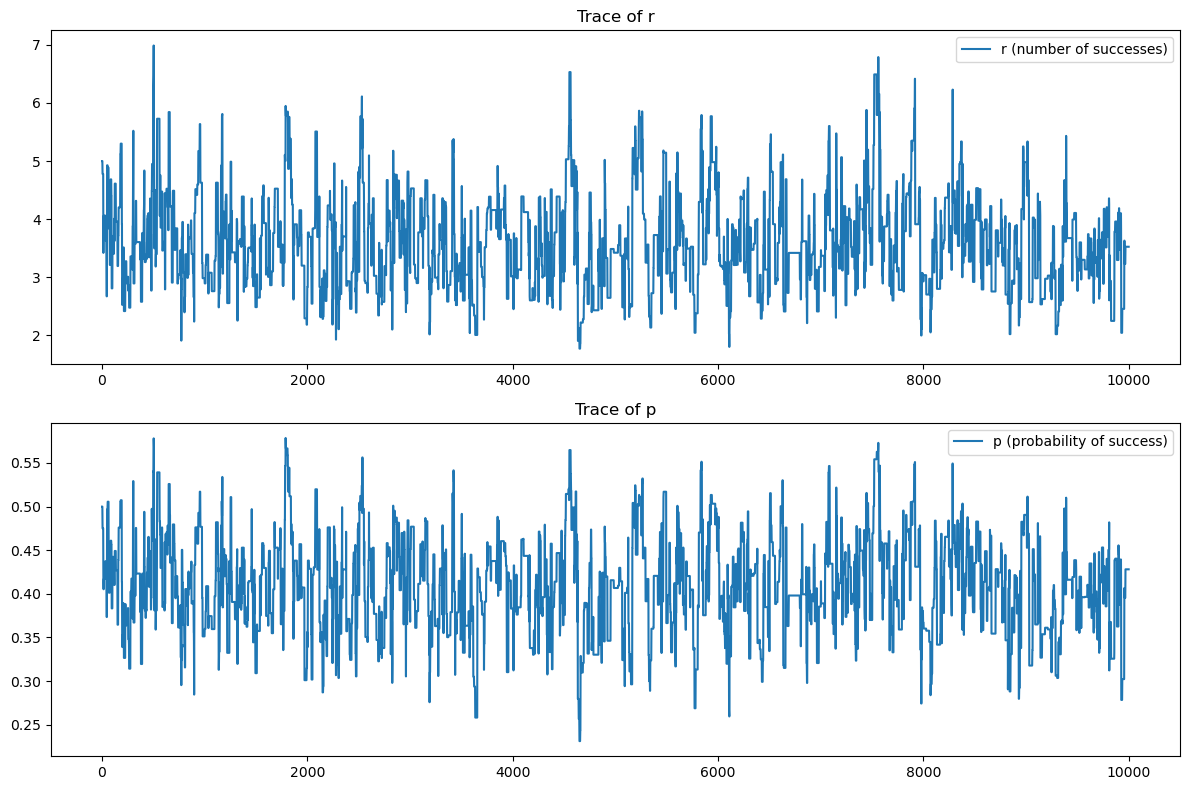

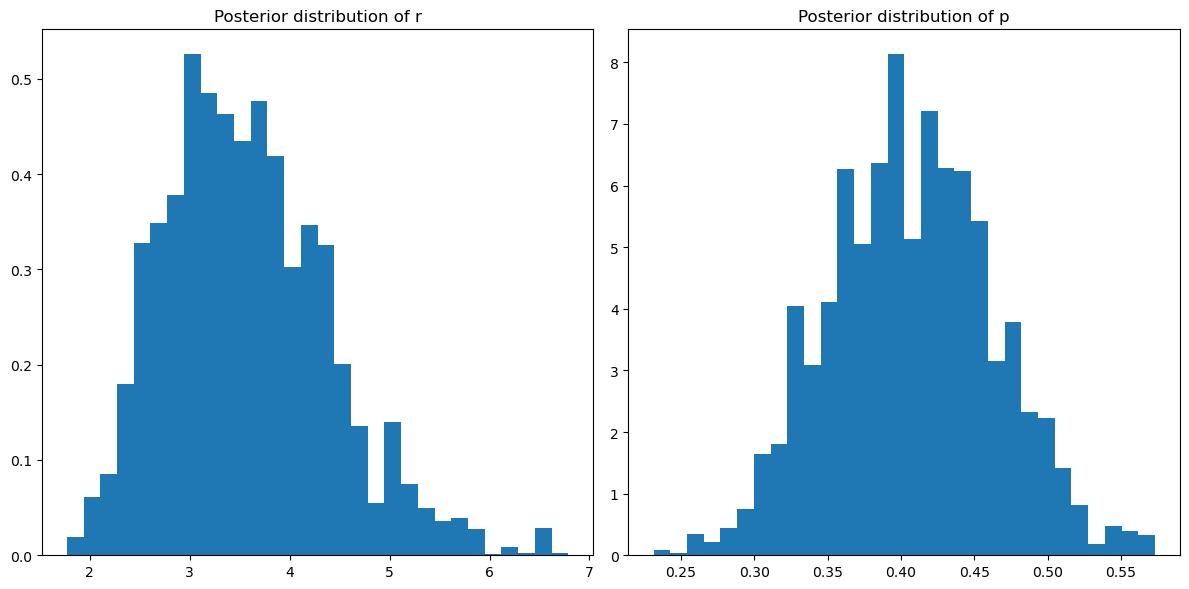

In [52]:

import scipy.stats as stats
import matplotlib.pyplot as plt

# Define the negative binomial likelihood
def neg_binom_likelihood(data, r, p):
    return np.sum(stats.nbinom.logpmf(data, r, p))

# Define the proposal distribution
def proposal_distribution(params, scale):
    return np.random.normal(params, scale, size=len(params))

# Metropolis-Hastings MCMC for negative binomial distribution
def metropolis_hastings(data, initial_params, iterations, proposal_scale):
    r_current, p_current = initial_params
    samples = np.zeros((iterations, 2))
    samples[0, :] = [r_current, p_current]
    
    for i in range(1, iterations):
        r_proposal, p_proposal = proposal_distribution([r_current, p_current], proposal_scale)
        
        # Ensure the proposals are in valid ranges
        if r_proposal <= 0 or p_proposal <= 0 or p_proposal >= 1:
            samples[i, :] = [r_current, p_current]
            continue
        
        # Compute the acceptance ratio
        likelihood_current = neg_binom_likelihood(data, r_current, p_current)
        likelihood_proposal = neg_binom_likelihood(data, r_proposal, p_proposal)
        
        prior_current = stats.gamma.logpdf(r_current, a=1, scale=1) + stats.beta.logpdf(p_current, a=1, b=1)
        prior_proposal = stats.gamma.logpdf(r_proposal, a=1, scale=1) + stats.beta.logpdf(p_proposal, a=1, b=1)
        
        posterior_current = likelihood_current + prior_current
        posterior_proposal = likelihood_proposal + prior_proposal
        
        acceptance_ratio = np.exp(posterior_proposal - posterior_current)
        
        if np.random.rand() < acceptance_ratio:
            r_current, p_current = r_proposal, p_proposal
        
        samples[i, :] = [r_current, p_current]
    
    return samples

# Example data (negative binomially distributed)
data = np.random.negative_binomial(n=5, p=0.5, size=100)

# Initial parameters, number of iterations, and proposal scale
initial_params = [5, 0.5]
iterations = 10000
proposal_scale = [1, 0.1]

# Run the MCMC simulation
samples = metropolis_hastings(data, initial_params, iterations, proposal_scale)

# Plot the parameter samples
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(samples[:, 0], label='r (number of successes)')
axs[0].set_title('Trace of r')
axs[0].legend()

axs[1].plot(samples[:, 1], label='p (probability of success)')
axs[1].set_title('Trace of p')
axs[1].legend()

plt.tight_layout()
plt.show()

# Discard burn-in period and plot histograms of the parameters
burn_in = int(iterations * 0.2)
r_samples = samples[burn_in:, 0]
p_samples = samples[burn_in:, 1]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(r_samples, bins=30, density=True)
plt.title('Posterior distribution of r')

plt.subplot(1, 2, 2)
plt.hist(p_samples, bins=30, density=True)
plt.title('Posterior distribution of p')

plt.tight_layout()
plt.show()


<bound method Series.mean of 0       30.321946
1       56.998655
2       34.060899
3       48.433953
4       11.599400
          ...    
2883    76.569801
2884    35.842777
2885    28.668374
2886    50.678805
2887    24.533582
Name: MT-CO1, Length: 2887, dtype: float64>


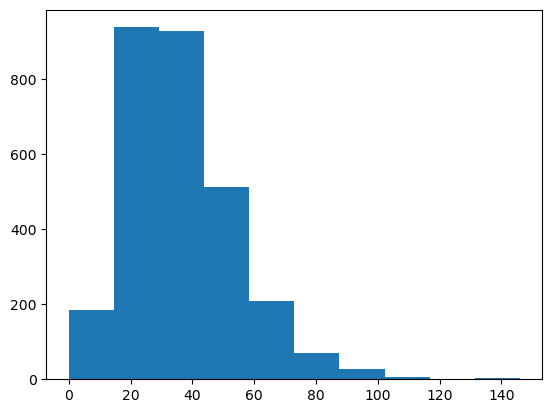

In [28]:
plt.hist(data1_cd4['MT-CO1'])
print(data1_cd4['MT-CO1'].mean)

0       30.321946
1       56.998655
2       34.060899
3       48.433953
4       11.599400
          ...    
2883    76.569801
2884    35.842777
2885    28.668374
2886    50.678805
2887    24.533582
Name: MT-CO1, Length: 2887, dtype: float64


/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_95686/3265625769.py:36: RuntimeWarning:

overflow encountered in exp



[[15.          0.1       ]
 [15.          0.1       ]
 [15.00093047  0.22962567]
 ...
 [14.81006747  0.28979216]
 [14.81006747  0.28979216]
 [14.81006747  0.28979216]]
[14.89047652  0.29251412]
0.03542306360924272


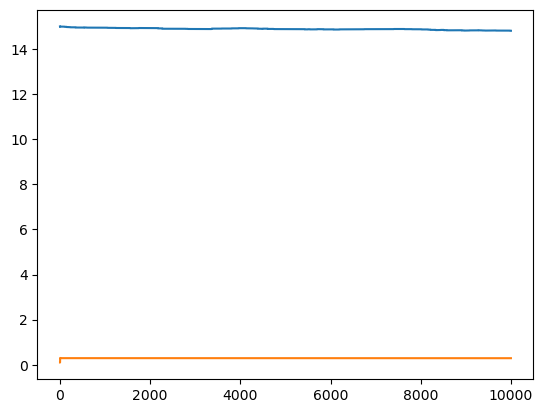

In [71]:
import numpy as np
import scipy.stats as stats

np.random.seed(42)

# Define the prior for r
def prior_r(r):
    return stats.poisson.logpmf(r, 2)

# Define the prior for prob
def prior_prob(prob):
    return stats.uniform.logpdf(prob, 0, 1)

# Define the log-likelihood
def loglikelihood(data, r, prob):
    return np.sum(stats.nbinom.logpmf(data, r, prob))

# Define the joint probability
def joint(r, prob,y):
    return loglikelihood(y, r, prob) + prior_r(r) + prior_prob(prob)

# Run the MCMC simulation
def run_mcmc(startvalue, iterations,y,c=3):
    chain = np.zeros((iterations + 1, 2))
    chain[0, :] = startvalue
    
    for i in range(iterations):
        proposal_r = np.random.poisson(chain[i, 0])
        proposal_prob = chain[i, 1] + np.random.uniform(max(-c, -chain[i, 1]), min(c, 1 - chain[i, 1]))
        
        if proposal_r > 0 and 0 <= proposal_prob <= 1:
            quotient = joint(proposal_r, proposal_prob,y) - joint(chain[i, 0], chain[i, 1],y)
            
            if np.random.rand() < min(1, np.exp(quotient)):
                chain[i + 1, :] = [proposal_r, proposal_prob]
            else:
                chain[i + 1, :] = chain[i, :]
        else:
            chain[i + 1, :] = chain[i, :]
    
    return chain

# Parameters for MCMC
iterations = 10000
startvalue = [15, 0.1]
proposal_scale=[0.005,0.1]
print(data1_cd4['MT-CO1'])
# Run the MCMC simulation
data = np.random.negative_binomial(n=4, p=0.1, size=3000)
# np.random.negative_binomial(n=4, p=0.1, size=3000)

res = metropolis_hastings(data, startvalue, iterations, proposal_scale)

print(res)
# Calculate the column means of the resulting chain
col_means = np.mean(res, axis=0)
print(col_means)
print(stats.nbinom.pmf(30, n=col_means[0], p=col_means[1]))
plt.plot(res)

In [163]:
from scipy.special import gammaln
from scipy.stats import truncnorm
y = data1_cd4['MT-ATP8']
N = len(y)
x = np.ones(N)
def nb_acceptance_ratio(theta, theta_p, y, N):
    """ theta = (mu, r), y is data, N = len(x) """
    mu, r = theta
    mu_p, r_p = theta_p
    
    term1 =  r_p * np.log(r_p / (r_p + mu_p))
    term2 = -r * np.log(r / (r + mu))
    
    term3 = y * np.log(mu_p / mu * (mu + r)/(mu_p + r_p))
    
    term4 = gammaln(r_p + y)
    term5 = - gammaln(r + y)
    
    term6 = N * (gammaln(r) - gammaln(r_p))
    
    return (term1 + term2 + term3 + term4 + term5).sum() + term6

def truncnorm_prop(x, sigma): # proposal for r (non-negative)
    return truncnorm.rvs(-x / sigma, np.Inf, loc=x, scale=sigma)

n_iter = 20000
burn_in = 10000

sigma_beta = 0.5
sigma_r = 0.5

def metropolis_hastings(n_iter, burn_in, thin=5):
    
    trace = np.zeros((n_iter, 2)) # ordered beta_0 beta_1 r
    trace[0,:] = np.array([5.,1.]) 
    acceptance_rate = np.zeros(n_iter)
    # store previous mu to avoid calculating each time 
    mu = trace[0,0]
    
    for i in range(1, n_iter):
        theta = trace[i-1,:] # theta = (beta_0, beta_1, r)
        
        theta_p = np.array([np.random.normal(theta[0], sigma_beta), 
                            truncnorm_prop(theta[1], sigma_r)]) 
        
        mu_p = theta_p[0]
        
        if np.any(mu <= 0):
            print( "mu == 0 on iteration %d" % i)

        alpha = nb_acceptance_ratio((mu, theta[1]), 
                                    (mu_p, theta_p[1]), y, N)
        
        u = np.log(np.random.uniform(0., 1.))*10

        if u < alpha:
            trace[i,:] = theta_p
            mu = mu_p
            acceptance_rate[i-1] = 1
        else:
            
            trace[i,:] = theta
        
            
    print( "Acceptance rate: %.2f" % acceptance_rate[burn_in:].mean())
    return trace[burn_in::thin,:]

trace = metropolis_hastings(n_iter, burn_in)

Acceptance rate: 0.73


In [104]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "out",
                 "ytick.direction": "out"})
    rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False
}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

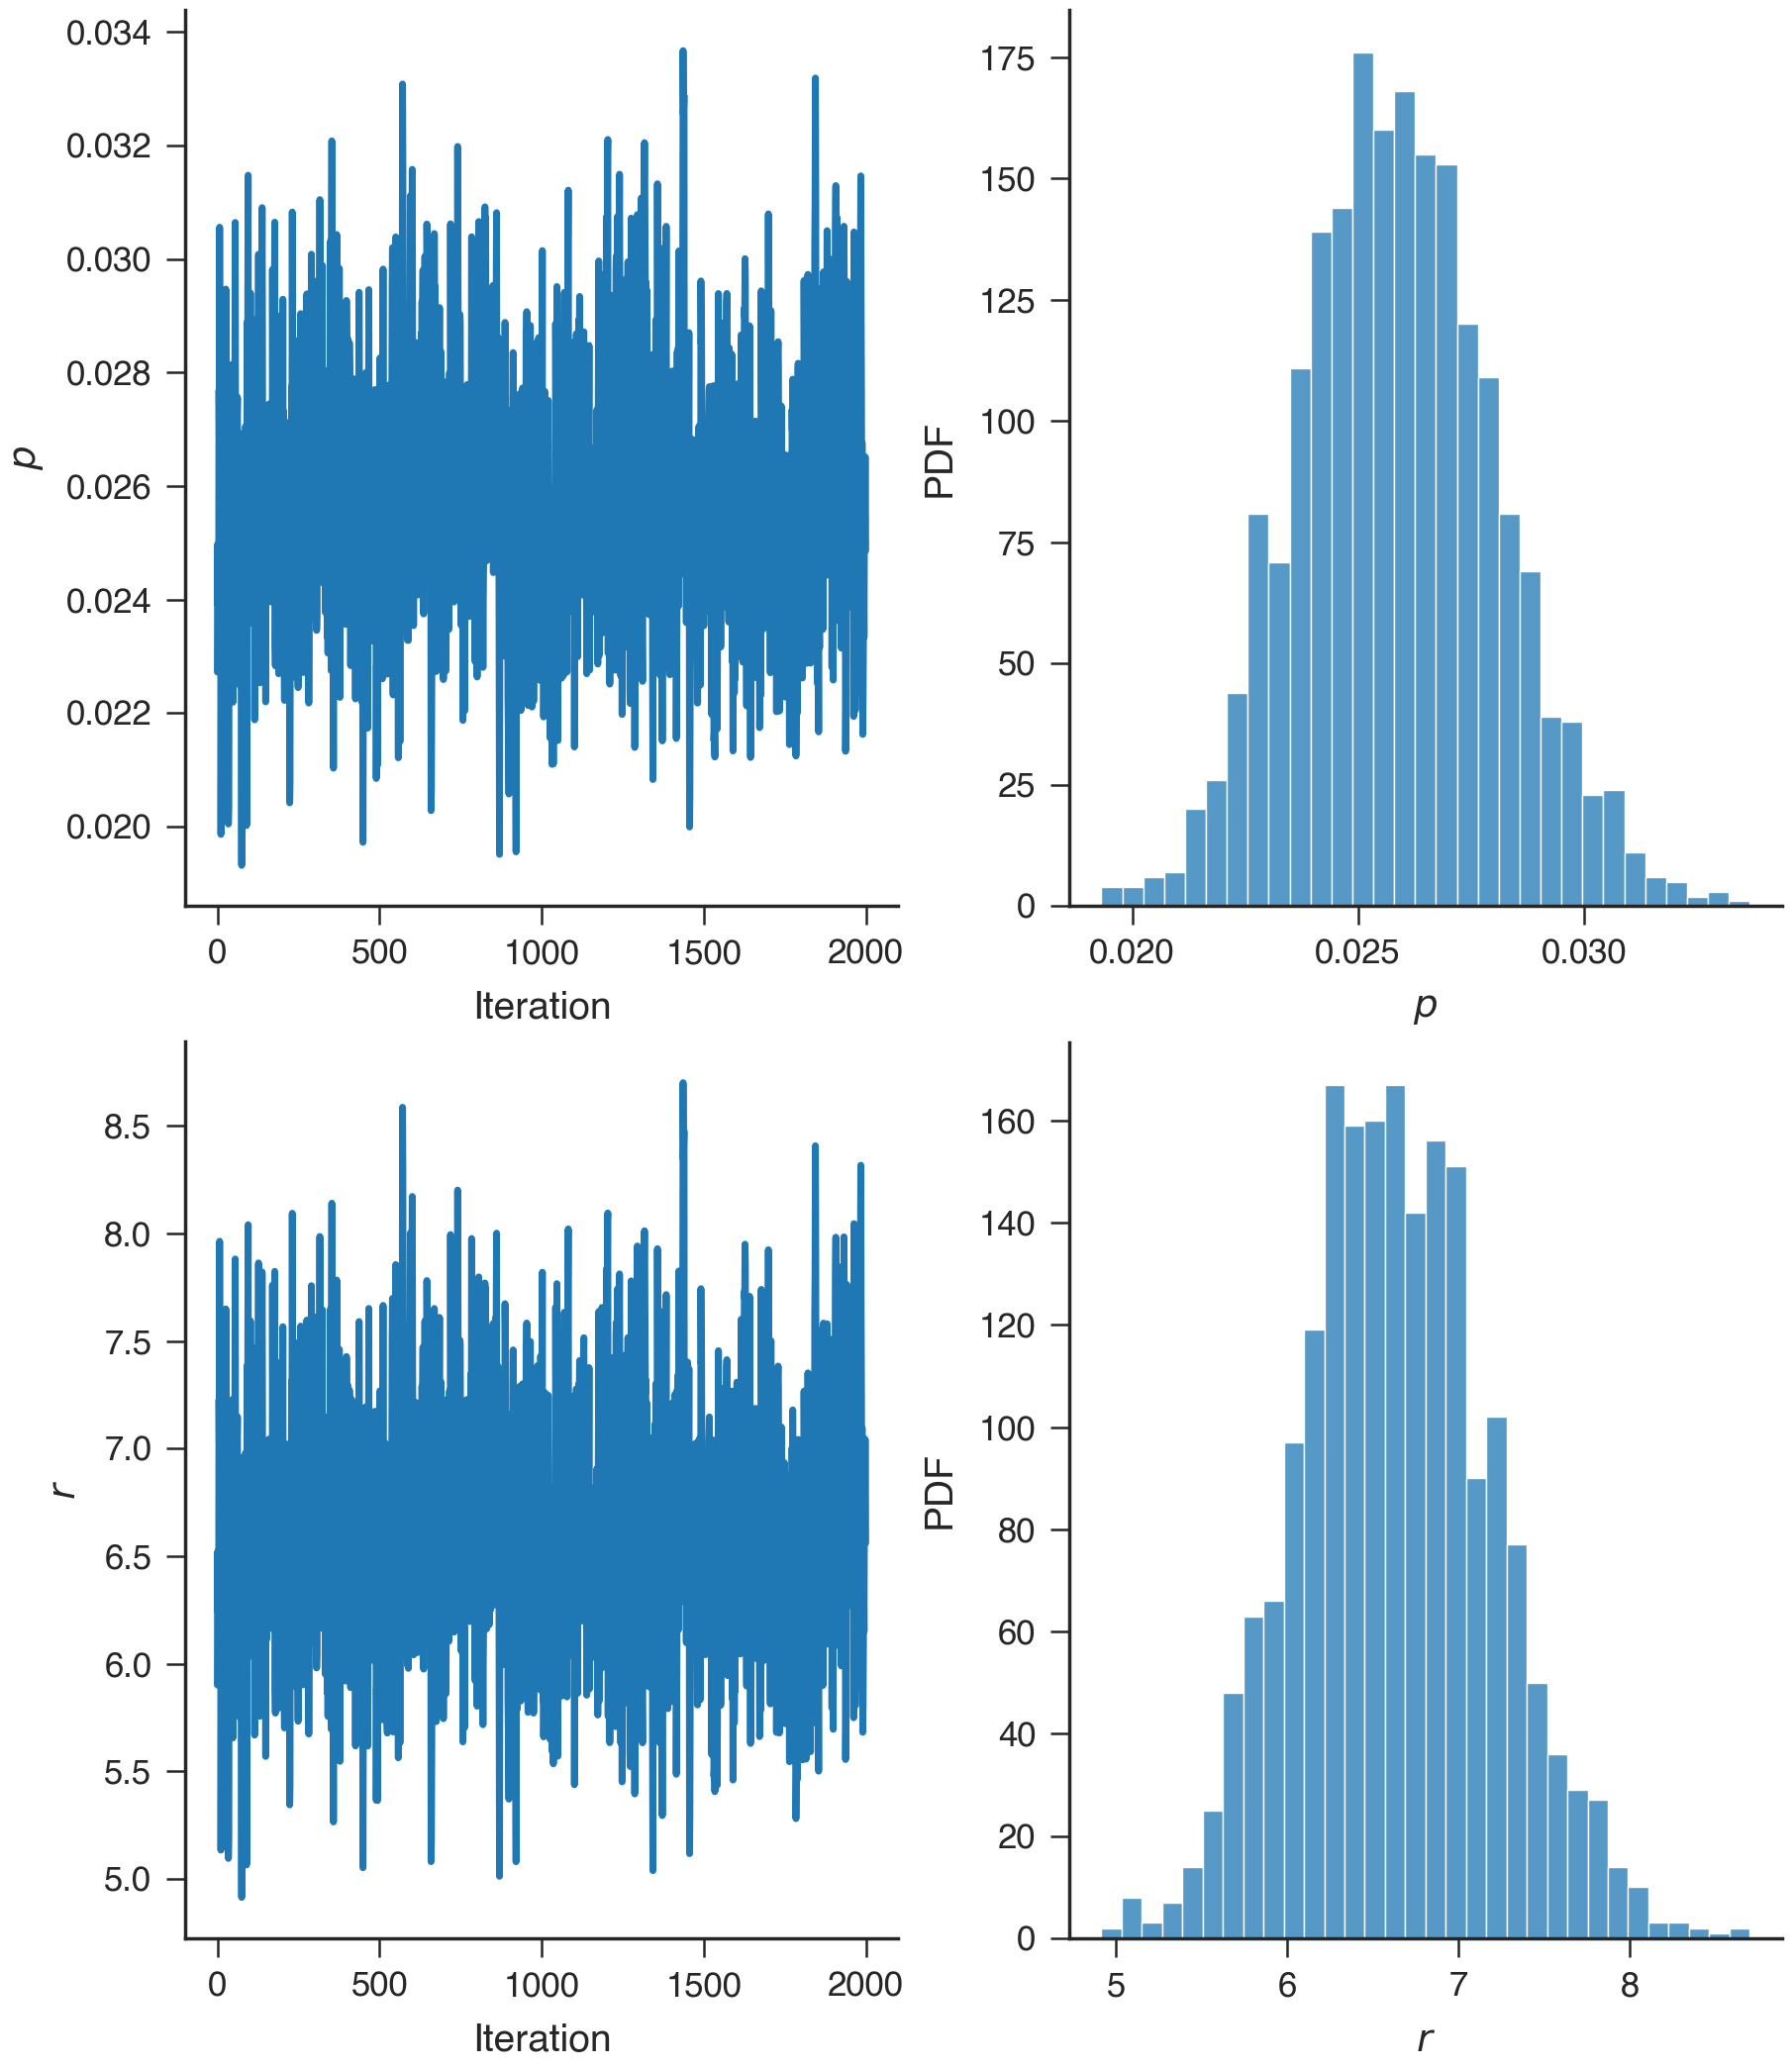

In [164]:
trace=pd.DataFrame(trace[:])
f, axs = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(nx=2, ny=3, scale=1))
p = 1 - trace[0] / (trace[1] + trace[0])
labels=[r'$p$',r'$r$']
count=0
ax=axs.flatten()[0]
ax.plot(p)
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[0])

ax=axs.flatten()[1]
sns.histplot(p,ax=ax)
ax.set_ylabel("PDF")
ax.set_xlabel(labels[0])

ax=axs.flatten()[2]
ax.plot(trace[1])
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[1])

ax=axs.flatten()[3]
sns.histplot(trace[1],ax=ax)
ax.set_ylabel("PDF")
ax.set_xlabel(labels[1])
f.tight_layout()

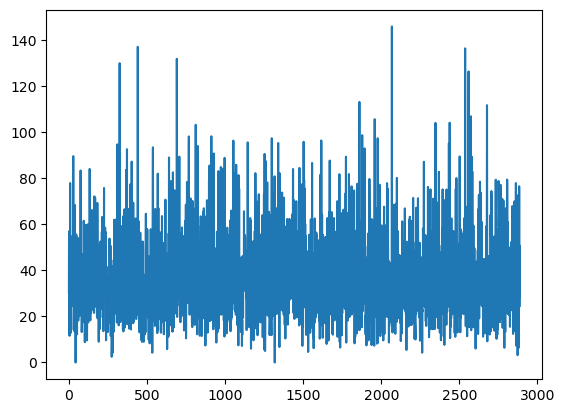

In [25]:
p = 1 - trace[0] / (float(trace[1]) + trace[0])

In [4]:
def copulas_check_cor(x:int,y:int,dataset, itr=10000,start_value=[4,0.25]):
    
    name_1 = str(protein_coding_genes[x])
    name_2 = str(protein_coding_genes[y])
    df_0 = dataset[[name_1, name_2]]
    # Data

    n = tl.filter_outliers(df_0)
    #fig = px.scatter(n, x = df_0.columns.values[0], y=df_0.columns.values[1], width=700, height=500, trendline='ols', trendline_color_override='DeepPink', marginal_x='histogram', marginal_y='histogram', title='mtDNA')
    #fig.show()

    res_1 = run_mcmc(start_value, itr,n[[name_1]])
    res_2 = run_mcmc(start_value, itr,n[[name_2]])
    x = np.array(range(0,61))
    
    # Calculate the column means of the resulting chain
    col_means_1 = np.mean(res_1, axis=0)
    col_means_2 = np.mean(res_2, axis=0)
    

    normal_cdf_1 =  pd.DataFrame(stats.nbinom.cdf(n[[name_1]], col_means_1[0], col_means_1[1]))
    normal_cdf_2 =  pd.DataFrame(stats.nbinom.cdf(n[[name_2]], col_means_2[0], col_means_2[1]))

    join_uniform = pd.concat([normal_cdf_1, normal_cdf_2], axis=1)
    join_uniform.columns = [name_1, name_2]

    time_v_money_uniform = px.scatter(join_uniform, x = name_1, y=name_2, width=1000, height=500,  marginal_x='histogram', marginal_y='histogram', title='joint distribution of uniform', trendline='ols', trendline_color_override='DeepPink', )
    time_v_money_uniform.show()
    return (round(join_uniform.corr().values[0][1],4))

a = copulas_check_cor(0,1,data1_cd4)
print(a)

NameError: name 'run_mcmc' is not defined

In [139]:
cor_o = np.zeros((13,13))
for i in range(13):
    for j in range(i+1,13):
        cor_o[i,j]=copulas_check_cor(i,j,data1_cd4)
print(cor_o)

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning

[[0.     0.5674 0.5725 0.5332 0.4255 0.3603 0.4405 0.3314 0.4748 0.4651
  0.2618 0.3025 0.5159]
 [0.     0.     0.6327 0.6112 0.4916 0.4021 0.4101 0.3283 0.5439 0.4074
  0.1784 0.273  0.614 ]
 [0.     0.     0.     0.6124 0.5308 0.4363 0.4309 0.3907 0.563  0.478
  0.2375 0.3202 0.6344]
 [0.     0.     0.     0.     0.533  0.4625 0.4635 0.3906 0.5736 0.4794
  0.2611 0.343  0.6226]
 [0.     0.     0.     0.     0.     0.4824 0.498  0.431  0.5348 0.4978
  0.3345 0.3888 0.5519]
 [0.     0.     0.     0.     0.     0.     0.4648 0.4352 0.4737 0.48
  0.3231 0.3788 0.4743]
 [0.     0.     0.     0.     0.     0.     0.     0.4379 0.4558 0.4789
  0.3344 0.3751 0.4633]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.3965 0.4294
  0.3291 0.3467 0.3945]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.4776
  0.2912 0.3648 0.5838]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.356  0.4075 0.4954]
 [0.     0.     0.     0.     0.     0.     0. 

In [137]:
cor = np.zeros((13,13))
for i in range(13):
    for j in range(i+1,13):
        cor[i,j]=copulas_check_cor(i,j)
print(cor)


/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/3179020824.py:38: RuntimeWarning

[[0.     0.5674 0.5726 0.5333 0.4254 0.3603 0.4407 0.3315 0.4747 0.4651
  0.2618 0.3023 0.5159]
 [0.     0.     0.6326 0.6111 0.4915 0.4017 0.4099 0.3283 0.5439 0.4071
  0.1782 0.2729 0.6141]
 [0.     0.     0.     0.6124 0.5308 0.4362 0.4309 0.3908 0.5631 0.4781
  0.2374 0.3202 0.6342]
 [0.     0.     0.     0.     0.533  0.4625 0.4634 0.3905 0.5735 0.4793
  0.2613 0.3429 0.6226]
 [0.     0.     0.     0.     0.     0.4825 0.498  0.4311 0.5348 0.4978
  0.3344 0.3888 0.5517]
 [0.     0.     0.     0.     0.     0.     0.4647 0.4353 0.4737 0.4801
  0.3231 0.3787 0.4742]
 [0.     0.     0.     0.     0.     0.     0.     0.4379 0.4558 0.4786
  0.3345 0.3752 0.4633]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.3963 0.4291
  0.3291 0.3466 0.3944]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.4776
  0.2913 0.3649 0.5837]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.3558 0.4073 0.4955]
 [0.     0.     0.     0.     0.     0.     

In [149]:
print(cor-cor_i)

[[ 0.     -0.0841 -0.0796 -0.0544 -0.1232 -0.0011 -0.0229 -0.0074 -0.0496
  -0.0316 -0.0659 -0.0633 -0.0879]
 [ 0.      0.     -0.0884 -0.0702 -0.1193 -0.0325 -0.0719 -0.0277 -0.0593
  -0.0685 -0.0476 -0.0519 -0.1017]
 [ 0.      0.      0.     -0.0762 -0.0704 -0.0308 -0.0618 -0.0217 -0.0696
  -0.0374 -0.0418 -0.0573 -0.072 ]
 [ 0.      0.      0.      0.     -0.072  -0.0254 -0.0696 -0.0411 -0.058
  -0.0535 -0.0324 -0.0573 -0.0567]
 [ 0.      0.      0.      0.      0.     -0.0491 -0.0561 -0.0241 -0.0818
  -0.0542 -0.0478 -0.0579 -0.1312]
 [ 0.      0.      0.      0.      0.      0.     -0.0594 -0.0418 -0.0461
  -0.056  -0.0541 -0.064  -0.0338]
 [ 0.      0.      0.      0.      0.      0.      0.     -0.0613 -0.0841
  -0.0717 -0.0659 -0.0978 -0.0683]
 [ 0.      0.      0.      0.      0.      0.      0.      0.     -0.0589
  -0.0523 -0.0647 -0.0675 -0.028 ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  -0.0715 -0.0407 -0.0682 -0.0706]
 [ 0.      0.      0.   

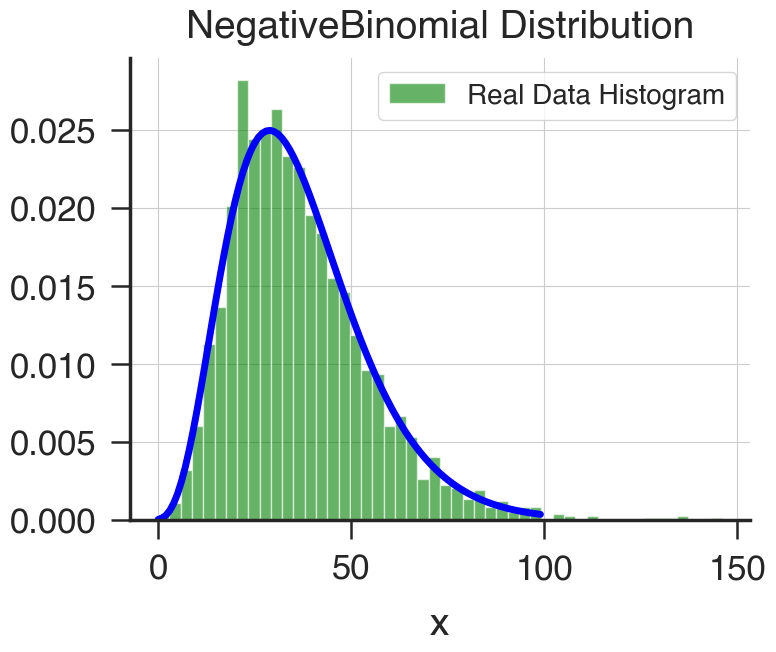

In [135]:
x = np.array(range(0,100))
col_means[0] = 5
col_means[1] = 0.12
# Compute the Gamma distribution PDF values
pmf = [stats.nbinom.pmf(i, n=col_means[0], p=col_means[1]) for i in x]

# Plot the Gamma distribution
plt.figure(figsize=(8, 6))
plt.plot(x, pmf,  color='b')
plt.hist(data1_cd4[['MT-CO1']],  bins=50,density=True, alpha=0.6, color='g', label='Real Data Histogram')

plt.title('NegativeBinomial Distribution')
plt.xlabel('x')
plt.legend()
plt.grid(True)
plt.show()


In [39]:


tes = np.array(data1_cd4[['MT-CO1']]).reshape(-1)
gene_cdf =  pd.DataFrame(stats.nbinom.cdf(df_0[['MT-CO1']], col_means[0], col_means[1]))
    


gene_cdf_vs_original = pd.concat([gene_cdf, df_0[['MT-CO1']]],axis = 1)
gene_cdf_vs_original.columns = ['CDF', 'Original']

gene_cdf_vs_original_plot = px.scatter(gene_cdf_vs_original, x = 'Original', y='CDF', width=1000, height=500, title='Two NB Cumulative Distribution Function for Genes',  marginal_x='histogram', marginal_y='histogram')
gene_cdf_vs_original_plot.show()

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/1893073041.py:38: RuntimeWarning:

overflow encountered in exp



[3.         0.08455398]


/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_82713/1893073041.py:38: RuntimeWarning:

overflow encountered in exp



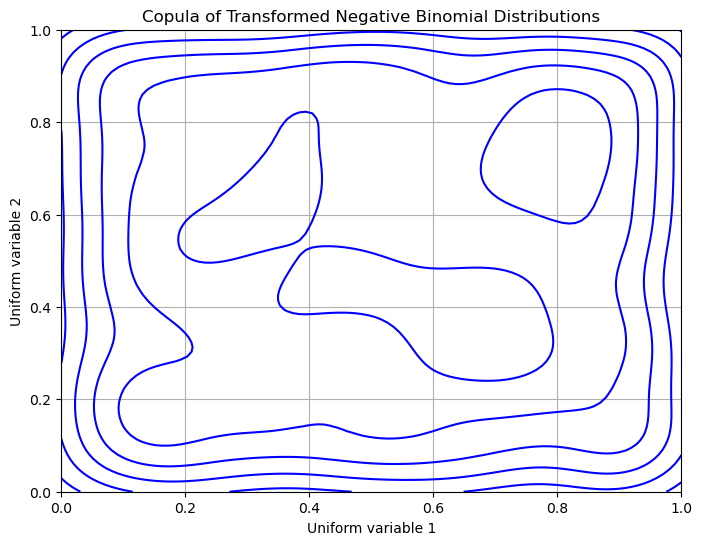

In [173]:

import scipy.stats as stats

import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

# Set the seed for reproducibility
np.random.seed(42)

# Generate two sets of negative binomial data
n = 2888

res_1 = run_mcmc(startvalue, iterations,np.array(data1_cd4[['MT-CO2']]))

res_1 = np.mean(res_1, axis=0)
print(res_1)
size1 = res_1[[0]]
prob1 = res_1[[1]]
res_2 = run_mcmc(startvalue, iterations,np.array(data1_cd4[['MT-CO3']]))
res_2 = np.mean(res_2,axis=0)
size2 = res_2[[0]]
prob2 = res_2[[1]]

x1 = np.random.negative_binomial(size1, prob1, n)
x2 = np.random.negative_binomial(size2, prob2, n)

# Transform to uniform distributions using the empirical CDF
ecdf1 = ECDF(x1)
ecdf2 = ECDF(x2)

u1 = ecdf1(x1)
u2 = ecdf2(x2)

# Combine the uniform distributions into a matrix
uniform_data = np.column_stack((u1, u2))

# Create a meshgrid for the contour plot
X, Y = np.mgrid[0:1:100j, 0:1:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

# Kernel Density Estimation
values = np.vstack([u1, u2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

# Plot the copula using contour plot
plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z, colors='blue')
plt.title('Copula of Transformed Negative Binomial Distributions')
plt.xlabel('Uniform variable 1')
plt.ylabel('Uniform variable 2')
plt.grid(True)
plt.show()



In [16]:

# Model
with pm.Model() as model:

    # Priors for the model parameters
    
    alpha = pm.Gamma('alpha', alpha=data_modelling['e_0'], beta=data_modelling['f_0'], shape=V)
    gamma = pm.Gamma('gamma', alpha=data_modelling['e_0'], beta=data_modelling['f_0'], shape=K)
    h = pm.Gamma('h', alpha=data_modelling['e_0'], beta=data_modelling['f_0'])
    # Initialize beta
    beta = pm.Normal('beta', mu=0, sigma=np.sqrt(1/alpha), shape=V)
    
    # Initialize Phi and theta
    Phi = pm.MvNormal('Phi', mu=np.zeros(V), cov=np.eye(V), shape=(V, V))
    theta = pm.Normal('theta', mu=0, sigma=1/np.sqrt(gamma), shape=(J, V))

    # Logistic function for p
    phi = pm.Deterministic('phi', np.dot(data_modelling['x'], beta.T) + np.dot(theta, Phi.T))
    p = pm.Deterministic('p', pm.math.sigmoid(phi))
    
    # Priors for the negative binomial parameters
    r_X = pm.Gamma('r_X', alpha=data_modelling['e_0'], beta=data_modelling['f_0'],shape=J)
    
    r_Y = pm.Gamma('r_Y', alpha=data_modelling['e_0'], beta=data_modelling['e_0'],shape=J)

    # Gaussian copula parameters
    chol, corr, stds = pm.LKJCholeskyCov('chol', n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True)
    
    # Copula latent variables
    u = pm.Normal('u', mu=0, sigma=1, shape=(2, len(observed_X)))
    copula_X = pm.Deterministic('copula_X', pm.math.invprobit(u[0, :]))
    copula_Y = pm.Deterministic('copula_Y', pm.math.invprobit(u[1, :]))

    # Negative Binomial likelihood
    X = pm.NegativeBinomial('X', n=r_X,p=1-p[:,0], observed=observed_X,shape=J)
    Y = pm.NegativeBinomial('Y', n=r_X,p=1-p[:,1], observed=observed_Y,shape=J)
    
    # Define a custom likelihood using the copula
    def bivariate_nb_likelihood(X, Y, r_X, p_X, r_Y, p_Y, corr):
        copula_X = pm.math.invprobit(X)
        copula_Y = pm.math.invprobit(Y)
        
        # Copula log likelihood
        copula_ll = (
            -0.5 * np.log(1 - corr[0, 1] ** 2)
            - 0.5 * (copula_X ** 2 + copula_Y ** 2 - 2 * corr[0, 1] * copula_X * copula_Y) / (1 - corr[0, 1] ** 2)
        )
        
        # Marginal Negative Binomial log likelihoods
        
        nb_X_ll = pm.logp(pm.NegativeBinomial.dist(mu=r_X * (1 - p_X) / p_X, alpha=r_X), r_X).sum().eval()
        nb_Y_ll = pm.logp(pm.NegativeBinomial.dist(mu=r_Y * (1 - p_Y) / p_Y, alpha=r_Y), r_Y).sum().eval()
        
        return copula_ll + nb_X_ll + nb_Y_ll

    # Custom likelihood
    pm.Potential('likelihood', bivariate_nb_likelihood(X, Y, r_X, p[:,0], r_Y, p[:,1], corr))

    # Inference
    trace = pm.sample(20, tune=10, cores=2)

# Summary
pm.summary(trace)



ValueError: Incompatible Elemwise input shapes [(2888, 13), (13, 13)]

In [14]:
cor_o_2 = np.zeros((13,13))
for i in range(13):
    for j in range(i+1,13):
        cor_o_2[i,j]=copulas_check_cor(i,j,dataset=data2_cd4)
print(cor_o_2)

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_45230/3113203376.py:34: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_45230/3113203376.py:34: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_45230/3113203376.py:34: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_45230/3113203376.py:34: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_45230/3113203376.py:34: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_45230/3113203376.py:34: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_45230/3113203376.py:34: RuntimeWarning:

overflow encountered in exp

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_45230/3113203376.py:34: RuntimeWarning

[[0.     0.531  0.5899 0.4572 0.3842 0.3331 0.4853 0.3684 0.4123 0.4298
  0.2054 0.3405 0.4725]
 [0.     0.     0.7023 0.7048 0.6071 0.5081 0.6601 0.5234 0.6749 0.5599
  0.2641 0.4469 0.6535]
 [0.     0.     0.     0.6965 0.6288 0.5071 0.6645 0.4964 0.6102 0.5091
  0.2353 0.4373 0.6678]
 [0.     0.     0.     0.     0.636  0.5228 0.6369 0.5229 0.6654 0.5494
  0.265  0.4296 0.6547]
 [0.     0.     0.     0.     0.     0.5411 0.638  0.4624 0.6317 0.5194
  0.2549 0.4118 0.6545]
 [0.     0.     0.     0.     0.     0.     0.4882 0.4088 0.506  0.4209
  0.2171 0.3687 0.5113]
 [0.     0.     0.     0.     0.     0.     0.     0.4959 0.6255 0.4974
  0.2467 0.4182 0.647 ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.5226 0.3957
  0.1959 0.3567 0.504 ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.5379
  0.251  0.4283 0.643 ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.4005 0.3383 0.5327]
 [0.     0.     0.     0.     0.     0.     

Mean Squared Error (MSE): 8.012818838304365e-07
Kullback-Leibler Divergence (KL Divergence): inf


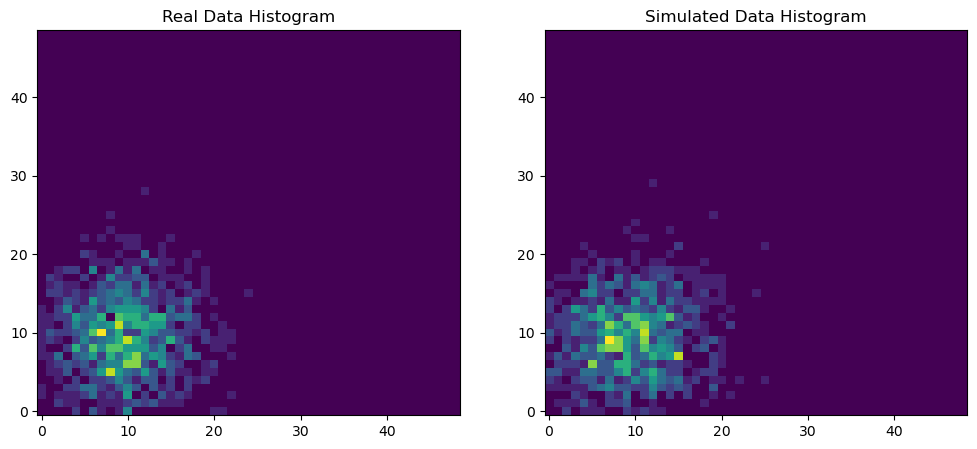

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Generate some sample data for demonstration
np.random.seed(42)
data_real = np.random.normal(loc=20, scale=10, size=(1000, 2))
data_simulated = np.random.normal(loc=20, scale=10, size=(1000, 2))

# Create histograms with the same binning
bins = [np.linspace(0, 100, 50), np.linspace(0, 100, 50)]

hist_real, xedges, yedges = np.histogram2d(data_real[:, 0], data_real[:, 1], bins=bins)
hist_simulated, _, _ = np.histogram2d(data_simulated[:, 0], data_simulated[:, 1], bins=bins)

# Normalize histograms
hist_real = hist_real / np.sum(hist_real)
hist_simulated = hist_simulated / np.sum(hist_simulated)

# Calculate Mean Squared Error (MSE)
mse = np.mean((hist_real - hist_simulated) ** 2)
print("Mean Squared Error (MSE):", mse)

# Calculate Kullback-Leibler Divergence (KL Divergence)
kl_divergence = entropy(hist_real.flatten(), hist_simulated.flatten())
print("Kullback-Leibler Divergence (KL Divergence):", kl_divergence)

# Visualize histograms for comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(hist_real.T, origin='lower', aspect='auto', interpolation='nearest')
ax[0].set_title('Real Data Histogram')
ax[1].imshow(hist_simulated.T, origin='lower', aspect='auto', interpolation='nearest')
ax[1].set_title('Simulated Data Histogram')
plt.show()
